In [1]:
from collections import namedtuple
import csv
import math
import numpy as np
import matplotlib.pyplot as plt

import nbimporter
import Weather as WEA
import SolarPosition as SP

Importing Jupyter notebook from Weather.ipynb
Importing Jupyter notebook from SolarPosition.ipynb


# 直散分離を計算するモジュール

## 1. Functions  

水平面全天日射量から水平面天空日射量と法線面直達日射量を計算する。

### 1.1. Watanabe Model

### 入力値  

$ I_G $ ：水平面全天日射量 [MJ/(m<sup>2</sup>･h)]  
$ h $ ：太陽高度角 (°)  

### 出力値

$ I_b $ ：法線面直達日射量 [MJ/(m<sup>2</sup>･h)]  
$ I_d $ ：水平面天空日射量 [MJ/(m<sup>2</sup>･h)]  

### 計算方法

#### データ構造と値の範囲

$ I_G $・$ h $の組み合わせを1つの変数（タプル）で表し"dbd_input"とする。  
$ h $は0°以上、90°以下の値をとる（ただし、$ h $が3°より小さい場合には、$ h $=3°として計算する）。  

In [2]:
#class dbd_input(namedtuple('dbd_input','dbd_ig dbd_h')):
#    __slots__ = ()

#dbd_ig：水平面全天日射量 [MJ/(m2･h)]  
#dbd_h：太陽高度角 (°) 

In [3]:
class dbd_input():
    def __init__( self, ig, h ):
        self.ig = ig
        self.h = h

#ig：水平面全天日射量 [MJ/(m2･h)]  
#h：太陽高度角 (°) 

#### 直散分離（Watanabe model）の計算

（参考：拡張アメダス気象データ1981-2000解説書 8.2.1　直散分離）  

直散分離（Watanabe model）の計算方法を以下に示す。  

$ \begin{align}I_d = I_0 ･ \sin h ･ \frac{Q}{1 + Q}\end{align}$ ･･････････････････････････････････ (3.3-a)  

$ \begin{align}Q = (0.8672 + 0.7505 ･ \sin h) ･ P ^ {\frac{0.421}{\sin h}} ･ (1 - P ^ {\frac{1}{\sin h}}) ^ {2.277}\end{align}$ ････ (3.3-b)  

大気透過率$ P $は、Bouguer式による。Bouguer式を以下に示す。

$ \begin{align}I_b = I_0 ･ P ^ {\frac{1}{\sin h}}\end{align}$ ･･････････････････････････････････････････ (3.3-c)  

日射の直散成分の関係式を以下に示す。 

$ \begin{align}I_G = I_b ･ \sin h + I_d\end{align}$ ･････････････････････････････････････ (3.3-d)  

ここで、  

$ I_0 $ ：法線面大気外日射量（1367[W/m<sup>2</sup>]=4.9212） [MJ/(m<sup>2</sup>･h)]  
$ P $ ：大気透過率（0 < $ P $ ≦ 0.85）  

である。  

式(3.3-c)、式(3.3-d)を整理すると、式(3.3-e)が得られる。  

$ \begin{align}I_d = I_G - I_0 ･ P ^ {\frac{1}{\sin h}} ･ \sin h\end{align}$ ･･･････････････････････････････ (3.3-e)  

大気透過率$ P $及び水平面天空日射量$I_d$は、式(3.3-a)と式(3.3-e)から収束計算によって求める。  

法線面直達日射量$I_b$は、式(3.3-d)を変形した式(3.3-f)から求める。  

$ \begin{align}I_b = \frac{I_G - I_d}{\sin h}\end{align}$ ･･････････････････････････････････････････ (3.3-f)  

In [4]:
#直散分離（Watanabe model）の計算
#法線面大気外日射量、水平面天空日射量
def division_beam_diffuse(L):

    dbd_i0 = 4.9212 #法線面大気外日射量(MJ/(m2h))
    #if 0. < L.dbd_h and L.dbd_h < 3.:
    if 0. < L.h and L.h < 3.:
        dbd_sinh =  math.sin(math.radians(3.)) #太陽高度角の補正
    #elif 3. < L.dbd_h and L.dbd_h <= 90.:
    elif 3. < L.h and L.h <= 90.:
        #dbd_sinh =  math.sin(math.radians(L.dbd_h))
        dbd_sinh =  math.sin(math.radians(L.h))
    else:
        dbd_sinh = 0.
        
    def f_id(dbd_px):
        dbd_q = (0.8672 + 0.7505 * dbd_sinh) * dbd_px ** (0.421 / dbd_sinh) * (1. - dbd_px ** (1. / dbd_sinh)) ** 2.277
        dbd_id1 = dbd_i0 * dbd_sinh * dbd_q / (1 + dbd_q)
        #dbd_id2 = L.dbd_ig - dbd_i0 * dbd_px ** (1 / dbd_sinh) * dbd_sinh
        dbd_id2 = L.ig - dbd_i0 * dbd_px ** (1 / dbd_sinh) * dbd_sinh
        return dbd_id1 - dbd_id2
    
    #収束計算(二分法)
    p_min = 0. #初期値(下限)
    p_max = 1. #初期値(上限)
    p_cnt = 0  #繰り返し回数
    #if dbd_sinh > 0. and L.dbd_ig > 0.:
    if dbd_sinh > 0. and L.ig > 0.:
        while True:
            p_cnt += 1
            dbd_p = (p_min + p_max) / 2.
            if f_id(p_min) * f_id(dbd_p) < 0.:
                p_max = dbd_p
            else:
                p_min = dbd_p
            if abs (f_id(dbd_p)) < 10. ** (-10.):
                if dbd_p > 0.85:
                    dbd_p = 0.85
                break
            elif p_cnt > 10. ** 3.:
                dbd_p = 99999.
                break
     
        if dbd_p != 99999.:
            #法線面直達日射量
            r_dbd_ib = dbd_i0 * dbd_p ** (1. / dbd_sinh)
            if r_dbd_ib > 4.18:
                r_dbd_ib = 4.18
            #水平面天空日射量
            #r_dbd_id = L.dbd_ig - r_dbd_ib * dbd_sinh
            r_dbd_id = L.ig - r_dbd_ib * dbd_sinh
            if r_dbd_id < 0.:
                r_dbd_id = 0.            
        else:
            r_dbd_ib = 99999.
            r_dbd_id = 99999.
    else:
        r_dbd_ib = 0.
        r_dbd_id = 0.
        
    return r_dbd_ib, r_dbd_id

#### Example

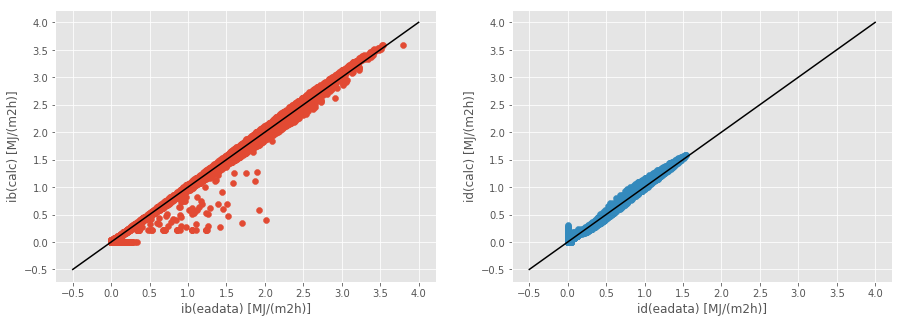

In [5]:
if __name__ == '__main__':

    location = '3639999'               #東京ID
    year = 1995                        #西暦年
    lat = 35. + 41.2 / 60.             #計算対象地点の緯度 (°)  
    lon = 139. + 45.9 / 60.            #計算対象地点の経度 (°)  

    #気象データ読込
    w = WEA.Weather(location)
    #ig = WEA.weather_input(location)[4]                                        #水平面全天日射量

    dbd_result = np.empty((5,8760))
    for i in range(0, 8760):
        sp_in = SP.sp_input(year, int((i + 1.) / 24.) + 1., ((i + 1.) / 24. - int((i + 1.) / 24.)) * 24., lat, lon)
        sp_h = SP.solar_position(sp_in)[0]                                     #太陽高度角   

        dbd_in = dbd_input(w.ig[i], sp_h)
        dbd_result[0][i] = i + 1.                                           #年通算時間
        dbd_result[1][i] = int((i + 1.) / 24.) + 1.                         #年通算日
        dbd_result[2][i] = ((i + 1.) / 24. - int((i + 1.) / 24.)) * 24.     #時刻
        dbd_result[3][i] = division_beam_diffuse(dbd_in)[0]                 #法線面直達日射量
        dbd_result[4][i] = division_beam_diffuse(dbd_in)[1]                 #水平面天空日射量

    #np.savetxt(location + '_out_dbd.csv', np.transpose(dbd_result), fmt='%.10f', delimiter=',')

    #確認用気象データ読込
    wc = WEA.WeatherConfirm(location)
    #ib_ea = WEA.weather_confirm_input(location)[0]                              #法線面直達日射量
    #id_ea = WEA.weather_confirm_input(location)[1]                              #水平面天空日射量

    #グラフの描画
    graph_num = 2
    ax = np.empty(graph_num, dtype = np.object)
    fig = plt.figure(figsize = (15, 5 * ((graph_num + 1) // 2)))
    plt.style.use('ggplot')

    gpc = ['C0', 'C1']
    #gxd = [[ib_ea[0:8760], [-0.5,4.]], [id_ea[0:8760], [-0.5,4.]]]
    gxd = [[wc.ib[0:8760], [-0.5,4.]], [wc.id[0:8760], [-0.5,4.]]]
    gyd = [[dbd_result[3][0:8760], [-0.5,4.]], [dbd_result[4][0:8760], [-0.5,4.]]]
    gxl = ['ib(eadata) [MJ/(m2h)]','id(eadata) [MJ/(m2h)]']
    gyl = ['ib(calc) [MJ/(m2h)]', 'id(calc) [MJ/(m2h)]']
    gxt = [[0.5 * (i-1) for i in range(10)], [0.5 * (i-1) for i in range(10)]]
    gyt = [[0.5 * (i-1) for i in range(10)], [0.5 * (i-1) for i in range(10)]]

    for i in range(graph_num):   
        ax[i] = fig.add_subplot((graph_num + 1) // 2, 2, i + 1)
        ax[i].scatter(gxd[i][0], gyd[i][0], color = gpc[i])
        ax[i].plot(gxd[i][1], gyd[i][1], color = (0,0,0))
        ax[i].set_xticks(gxt[i])
        ax[i].set_yticks(gyt[i])
        ax[i].set_xlabel(gxl[i], fontsize = 12)
        ax[i].set_ylabel(gyl[i], fontsize = 12)

    plt.show()